In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from datalib import *
import config.config_create_trajectory as config

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.optimize as optimization
from bisect import bisect
import time as t

%matplotlib notebook

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
start_time = t.time()
print("Reading demonstration data")

position_data = []
velocity_data = []

starting_indices = []
ending_indices = []

for i in range(len(config.demos)):
    demo = config.demos[i]
    print(f'Reading demonstration file {demo}')

    position_data.append(PositionDataSet())
    velocity_data.append(PositionDataSet())

    # Read data
    franka_reader = FrankaStateReader(demo)
    
    while not franka_reader.end():
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value
        
        position_data[i].append(PositionDataPoint(time, franka_state.position))
        velocity_data[i].append(PositionDataPoint(time, franka_state.force_external))
        
    # Align time
    position_data[i].align_time()
    velocity_data[i].align_time()

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo8.bag
Reading demonstration file data/demo9.bag
Reading demonstration file data/demo10.bag
--- 31.788813829421997 seconds ---
Done


In [3]:
def fitting_func(t, a, A, gamma, omega, phi, v_min):
    result = []
    if not isinstance(t, (np.ndarray, np.generic)):
        if isinstance(t, list):
            t = np.array(t)
        else:
            t = np.array([t])

    for timestamp in t:
        result.append(v_min + a*timestamp + A*(math.exp(gamma * timestamp) * math.cos(omega*timestamp + phi) - math.cos(phi)))
    return np.array(result)

In [4]:
start_time = t.time()
print("Fitting curves")

velocity_to_be_fitted_data = []
fitted_data = []
fitted_linear_data = []

impact_indices_data = []
ante_impact_velocity_data = []
impact_phase_velocity_data = []
post_impact_velocity_data = []

# config.impact_duration = 0.09

for i in range(len(config.demos)):
    
    velocity_to_be_fitted_data.append(PositionDataSet())
    fitted_data.append(PositionDataSet())
    fitted_linear_data.append(PositionDataSet())
    
    # Impact phase
    ending_index = config.impact_intervals[i][0][0] - config.impact_detection_delays[i][0]
    starting_index = config.impact_intervals[i][0][-1] - config.impact_detection_delays[i][-1]
    impact_indices = []
    for j in range(len(config.impact_intervals[i][0])):
        if j > 0:
            impact_indices.append(config.impact_intervals[i][0][j] - config.impact_detection_delays[i][-1])
        else:
            impact_indices.append(config.impact_intervals[i][0][j] - config.impact_detection_delays[i][0])
    
    impact_indices_data.append(impact_indices)
    
    ante_impact_position = position_data[i][:ending_index].copy()
    impact_phase_position = position_data[i][ending_index:starting_index].copy()
    post_impact_position = position_data[i][starting_index:].copy()
    detected_impact_position = PositionDataSet([position_data[i][j] for j in impact_indices]).copy()
    
    ante_impact_velocity = velocity_data[i][:ending_index].copy()
    impact_phase_velocity = velocity_data[i][ending_index:starting_index].copy()
    post_impact_velocity = velocity_data[i][starting_index:].copy()
    detected_impact_velocity = PositionDataSet([velocity_data[i][j] for j in impact_indices]).copy()
    
    ante_impact_velocity_data.append(ante_impact_velocity)
    impact_phase_velocity_data.append(impact_phase_velocity)
    post_impact_velocity_data.append(post_impact_velocity)
    
    impact_phase_ending_index = 0
    last_impact_time = impact_phase_position[-1].time
    while post_impact_position[impact_phase_ending_index].time < last_impact_time + config.impact_duration:
        impact_phase_ending_index += 1
        
    velocity_data_to_fit = []
    fitted_velocity_data = []
    fitted_linear_velocity_data = []
        
    for j in range(3):   
        
        fitted_linear_velocity_data.append(DataSet())
        fitted_velocity_data.append(DataSet())
        
        data_to_fit = post_impact_velocity[:impact_phase_ending_index].get_index(j).copy()
        time_shift = data_to_fit[0].time
        data_to_fit.align_time()
        
        ante_impact_velocity_value = impact_phase_velocity[-1][j].value
        func = lambda t, a, A, gamma, phi, omega : fitting_func(t, a, A, gamma, omega, phi, ante_impact_velocity_value)
        omega = 2*math.pi / (config.impact_duration/3)
        p0 = [0, 1/100, 0, 0, omega]
        bounds = ((-np.inf, 0, -np.log(10)/((3/2)*config.impact_duration/3), -np.pi, (2/3)*omega), (np.inf, np.inf, 0, np.pi, (3.2)*omega))
        
        p, pcov = optimization.curve_fit(func, np.array(data_to_fit.time), np.array(data_to_fit.value), p0=p0,bounds=bounds, maxfev=1000000)
        print(f'a: {"{:.2f}".format(p[0])}, A: {"{:.4f}".format(p[1])}, \N{greek small letter gamma}: {"{:.2f}".format(p[2])}, \N{greek small letter phi}: {"{:.2f}".format(p[3])}, \N{greek small letter omega}: {"{:.2f}".format(p[4])}')
        
        fitted_velocity_data_values = func(data_to_fit.time, p[0], p[1], p[2], p[3], p[4])
        fitted_linear_velocity_data_values = func(data_to_fit.time, p[0], 0, 0, 0, 0)
        
        for k in range(len(fitted_velocity_data_values)):
            fitted_velocity_data[j].append(DataPoint(data_to_fit.time[k] + time_shift, fitted_velocity_data_values[k]))
            fitted_linear_velocity_data[j].append(DataPoint(data_to_fit.time[k] + time_shift, fitted_linear_velocity_data_values[k] - p[1] * math.cos(p[3])))
        
        data_to_fit.align_time(time_shift)
        velocity_data_to_fit.append(data_to_fit)
    
    for k in range(len(fitted_velocity_data[0])):
        time = fitted_velocity_data[0][k].time
        value = []
        fitted_value = []
        fitted_linear_value = []
        for j in range(3):
            value.append(velocity_data_to_fit[j][k].value)
            fitted_value.append(fitted_velocity_data[j][k].value)
            fitted_linear_value.append(fitted_linear_velocity_data[j][k].value)
        velocity_to_be_fitted_data[i].append(PositionDataPoint(time, value))
        fitted_data[i].append(PositionDataPoint(time, fitted_value))
        fitted_linear_data[i].append(PositionDataPoint(time, fitted_linear_value))
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Fitting curves
a: 5.21, A: 0.4211, γ: -16.70, φ: 2.51, ω: 279.64
a: 2.99, A: 3.5176, γ: -23.03, φ: 2.68, ω: 202.98
a: -122.01, A: 8.4960, γ: -23.03, φ: -0.47, ω: 124.61
a: 2.60, A: 0.5334, γ: -23.03, φ: -2.08, ω: 239.38
a: -8.27, A: 5.1453, γ: -23.03, φ: -3.14, ω: 62.83
a: -123.92, A: 8.6146, γ: -23.03, φ: -0.04, ω: 123.26
a: 3.65, A: 0.2729, γ: -5.37, φ: -2.99, ω: 62.83
a: -10.66, A: 4.9857, γ: -23.03, φ: -3.14, ω: 62.83
a: -115.52, A: 7.9958, γ: -23.03, φ: -0.13, ω: 119.98
--- 0.8281450271606445 seconds ---
Done


<IPython.core.display.Javascript object>


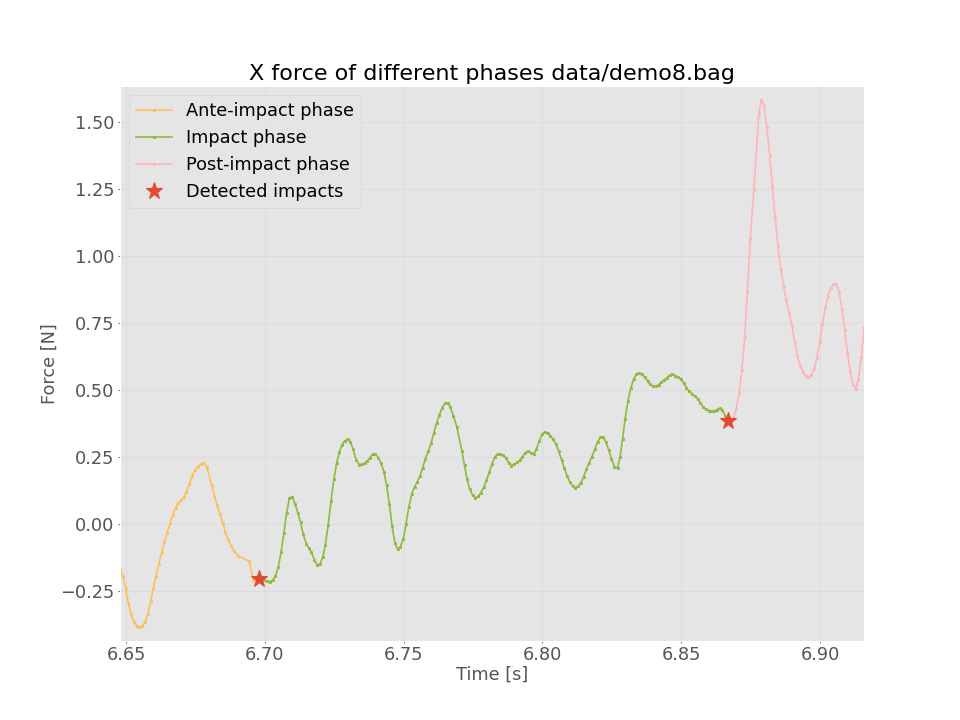

<IPython.core.display.Javascript object>


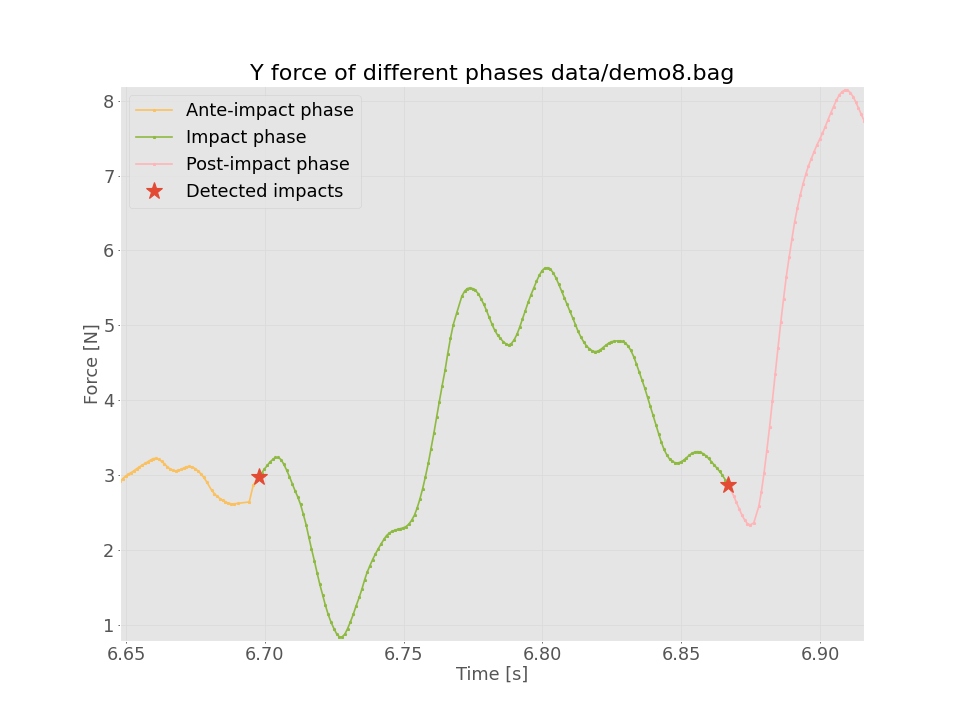

<IPython.core.display.Javascript object>


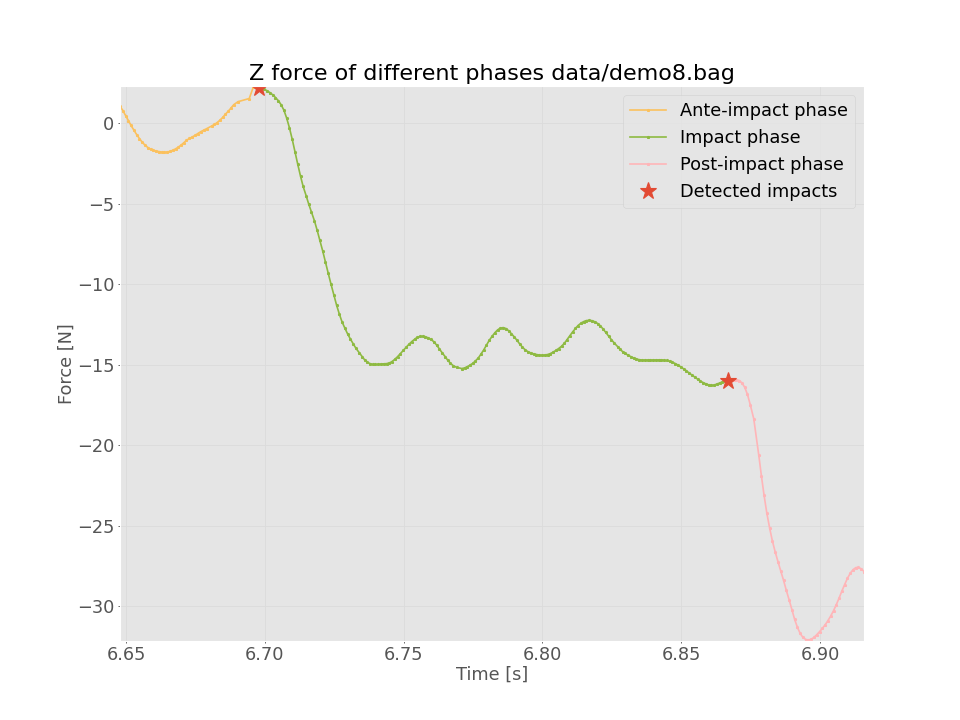

<IPython.core.display.Javascript object>


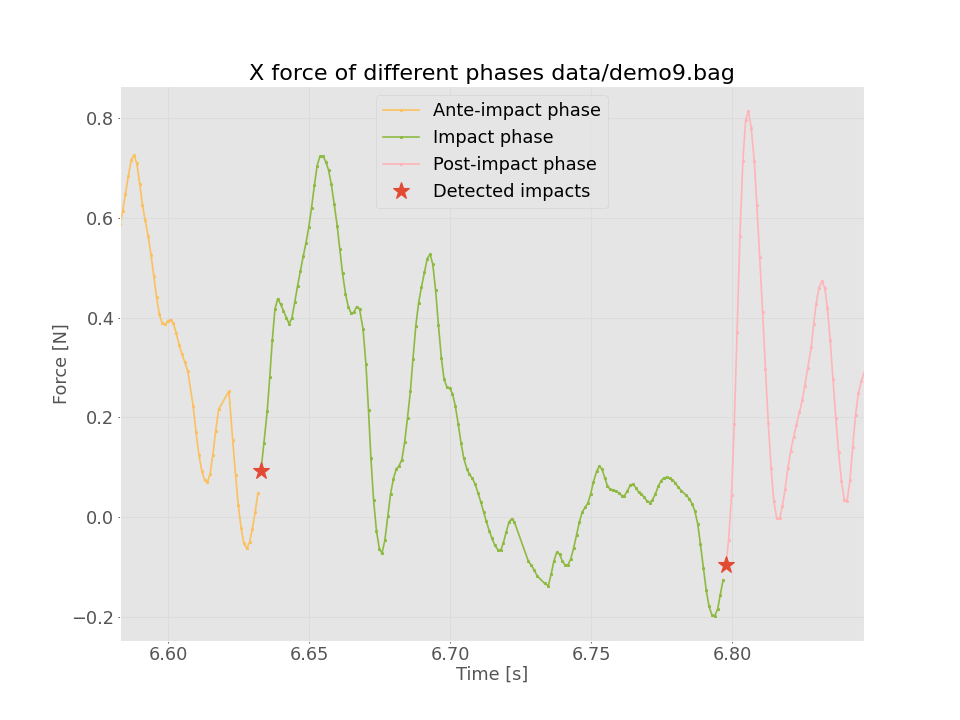

<IPython.core.display.Javascript object>


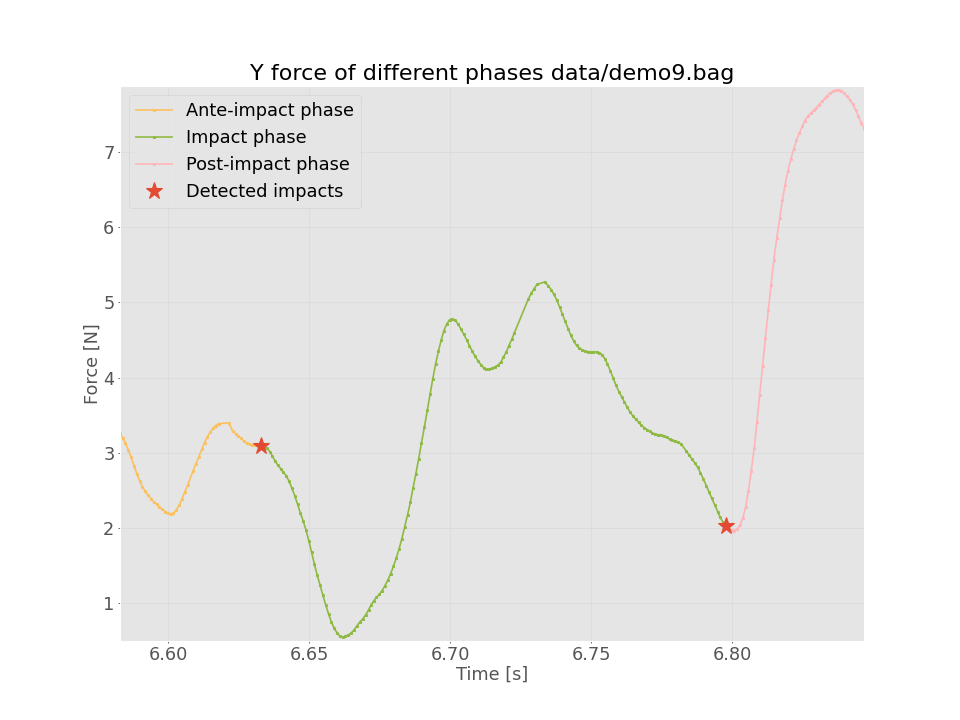

<IPython.core.display.Javascript object>


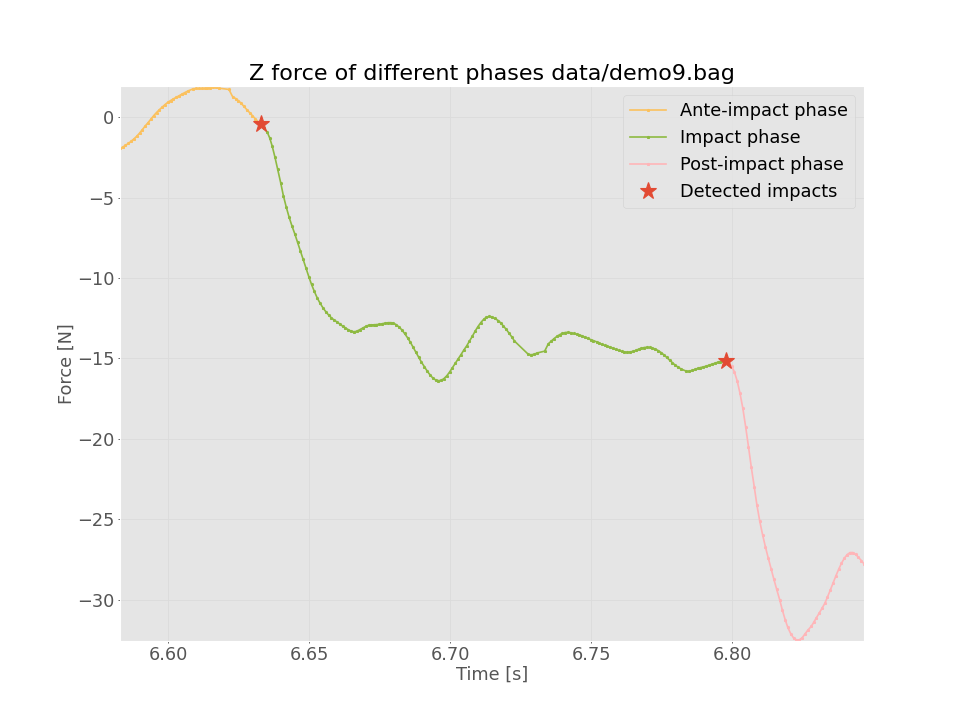

<IPython.core.display.Javascript object>


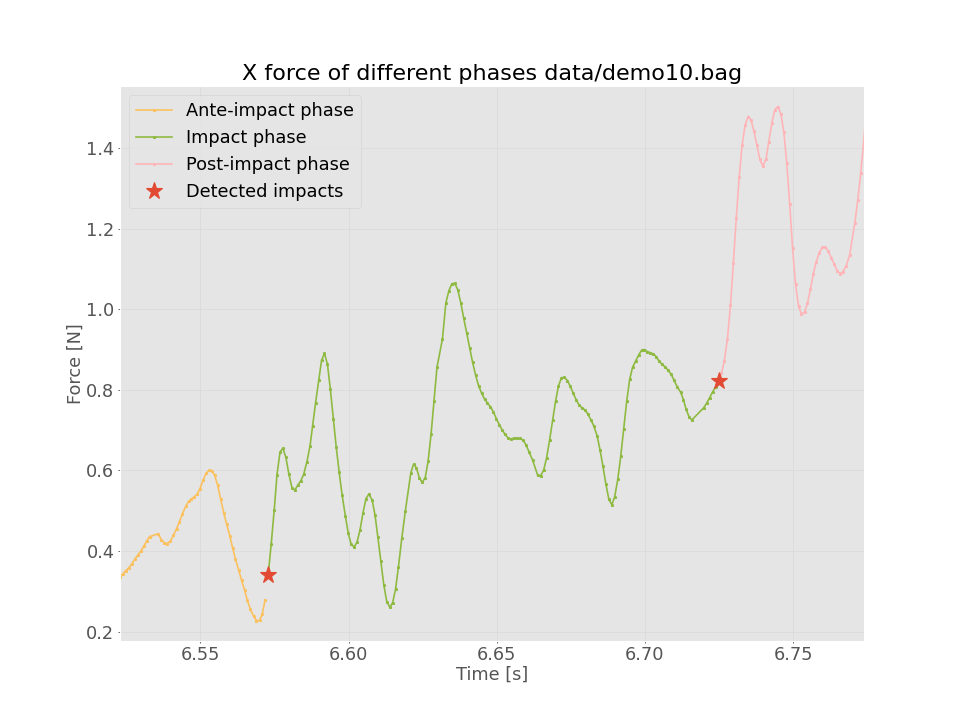

<IPython.core.display.Javascript object>


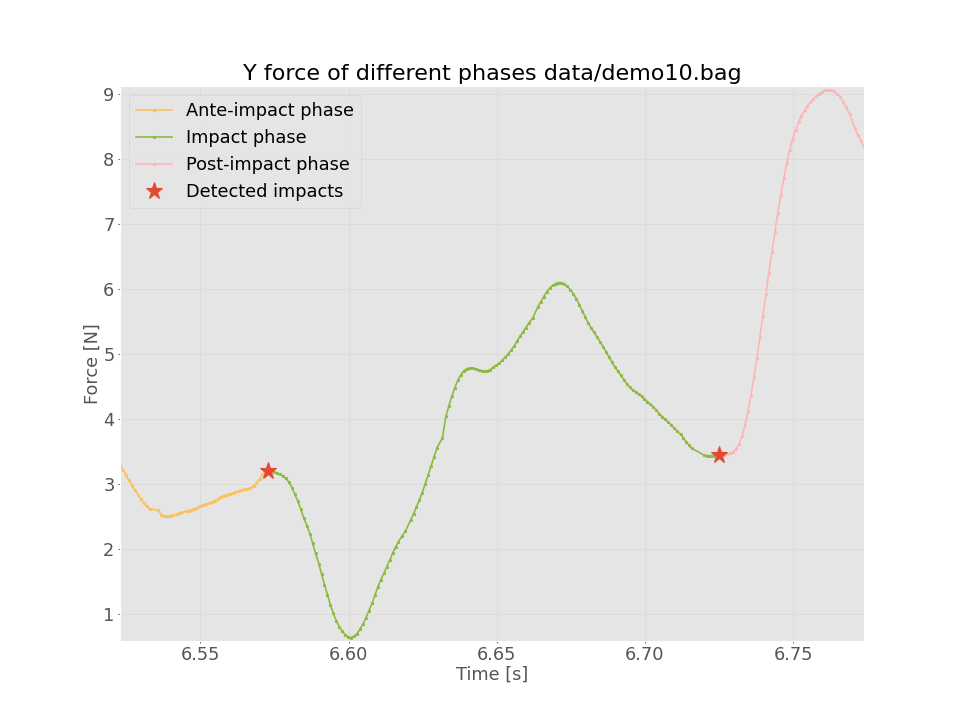

<IPython.core.display.Javascript object>


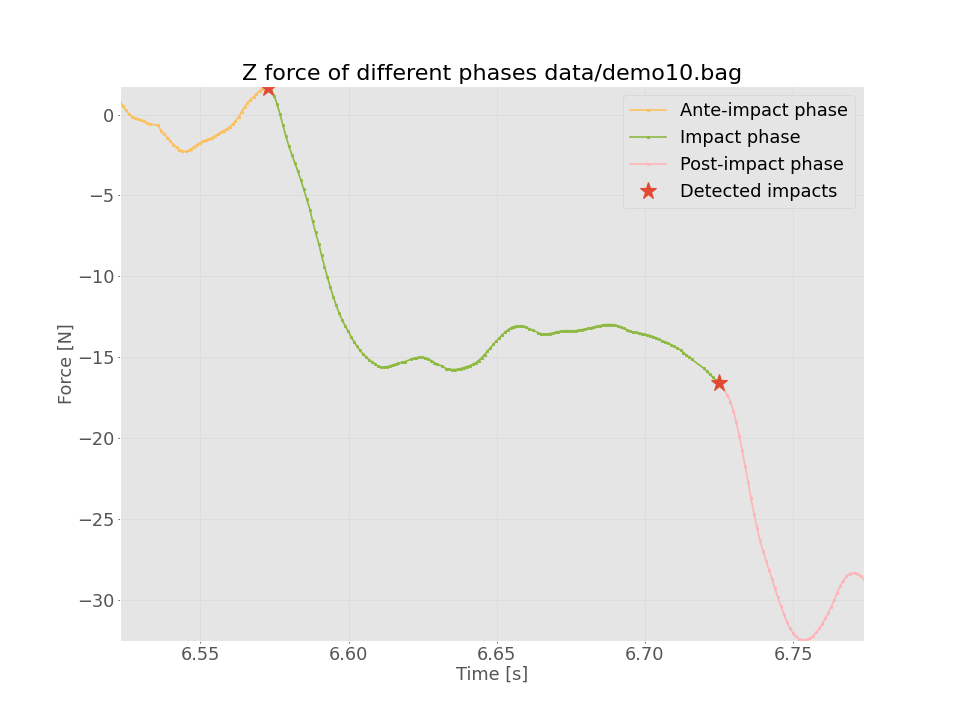

In [5]:
# Plot velocity

for i in range(len(config.demos)):
    for j in range(3):
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        plt.plot(ante_impact_velocity_data[i].time, ante_impact_velocity_data[i].get_index(j).value, f'C{4}-*', linewidth=config.linewidth, markersize=config.markersize3,label='Ante-impact phase')
        plt.plot(impact_phase_velocity_data[i].time, impact_phase_velocity_data[i].get_index(j).value, f'C{5}-*', linewidth=config.linewidth, markersize=config.markersize3,label='Impact phase')
        plt.plot(post_impact_velocity_data[i].time, post_impact_velocity_data[i].get_index(j).value, f'C{6}-*', linewidth=config.linewidth, markersize=config.markersize3,label='Post-impact phase')
        detected_impacts = velocity_data[i][impact_indices_data[i]]
        plt.plot(detected_impacts.time, detected_impacts.get_index(j).value, 'C0*', markersize=config.markersize1,label='Detected impacts')
    
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Force [N]',fontsize=config.fontsize2)
        plt.title(f'{config.labels[j]} force of different phases ' + config.demos[i],fontsize=config.fontsize1)
        if config.xlim is not None:
            x_min = impact_phase_velocity_data[i][0].time + config.xlim[0]
            x_max = impact_phase_velocity_data[i][-1].time + config.xlim[-1]
            sub_ydata = velocity_data[i][bisect(velocity_data[i].time, x_min):bisect(velocity_data[i].time, x_max)].get_index(j).value
            plt.xlim((x_min, x_max))
            plt.ylim((min(sub_ydata) - 0.05, max(sub_ydata) + 0.05))

<IPython.core.display.Javascript object>


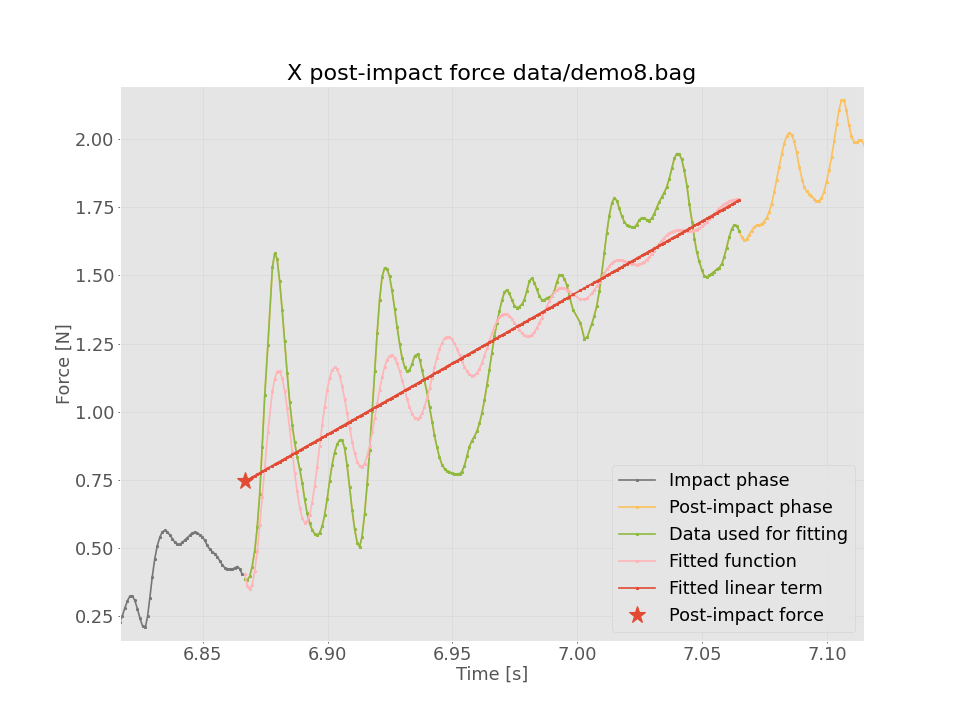

<IPython.core.display.Javascript object>


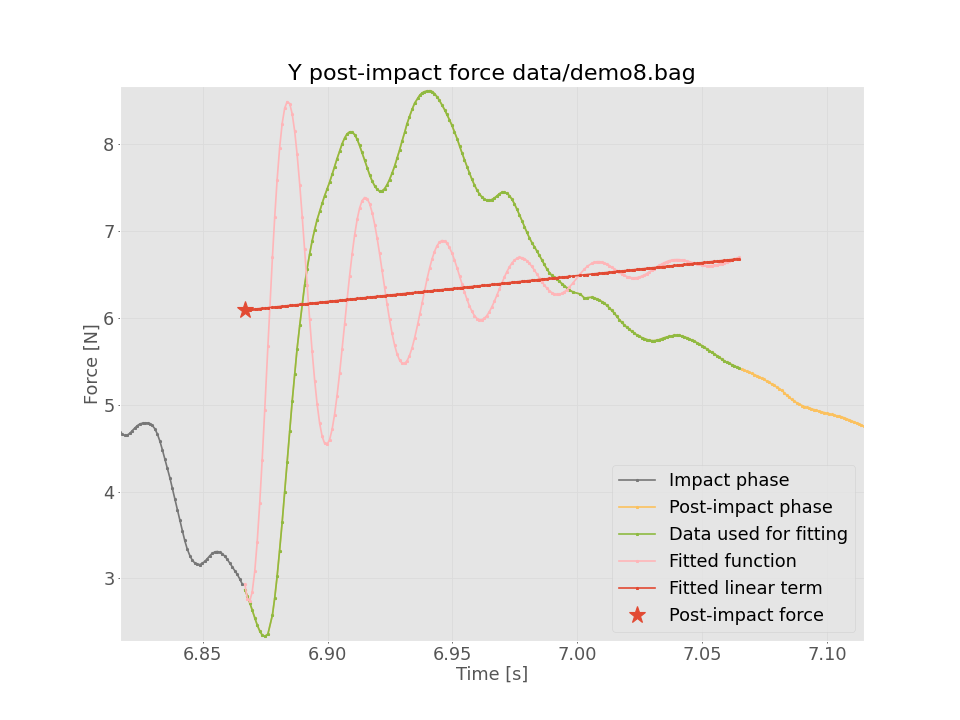

<IPython.core.display.Javascript object>


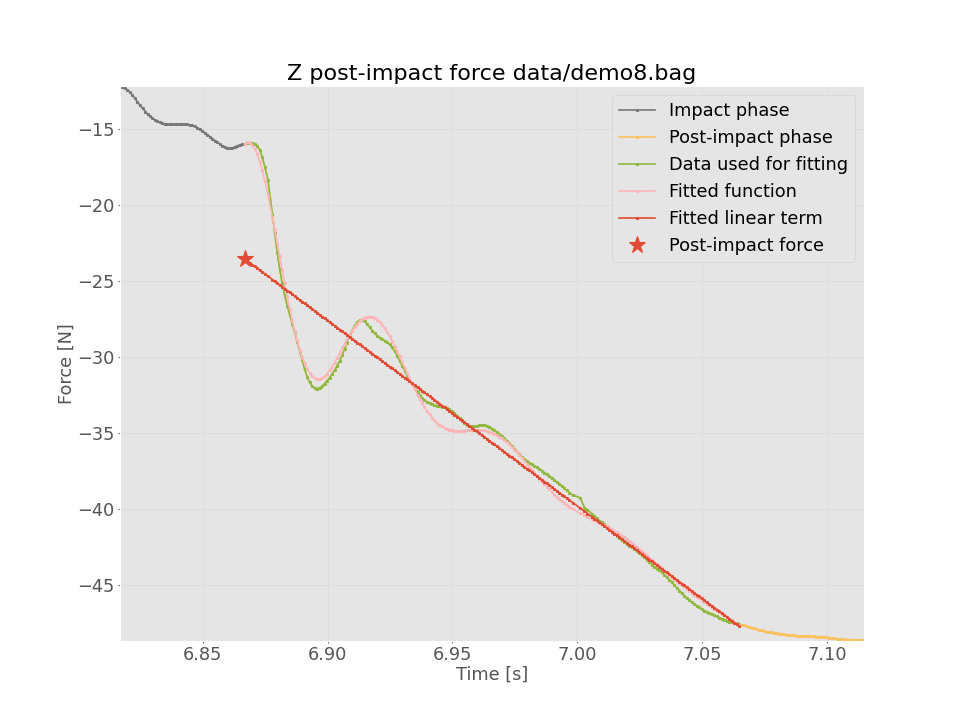

<IPython.core.display.Javascript object>


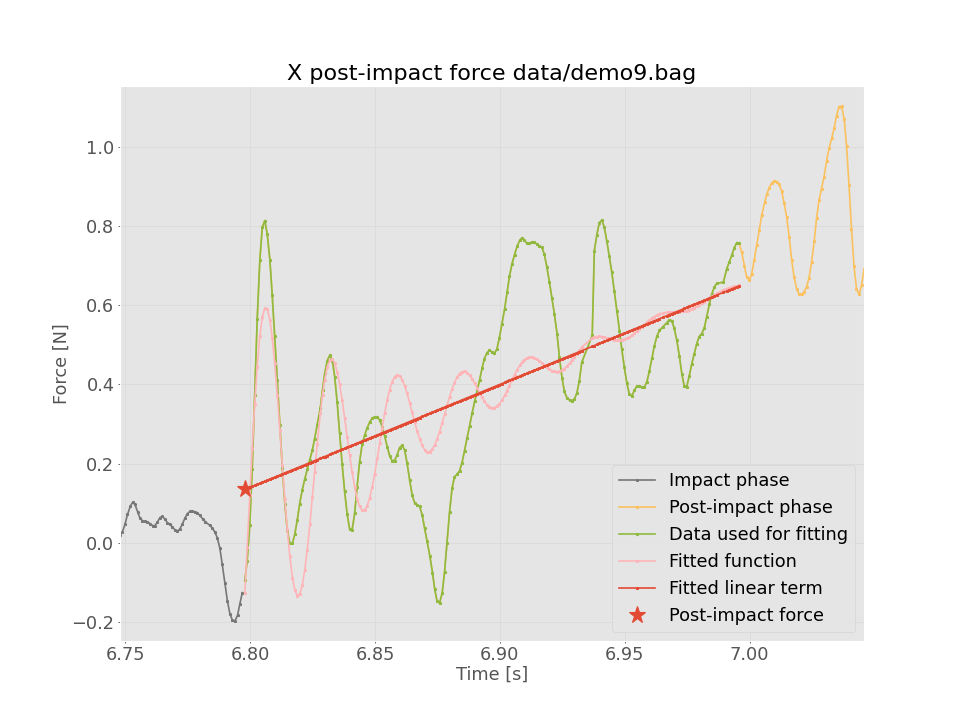

<IPython.core.display.Javascript object>


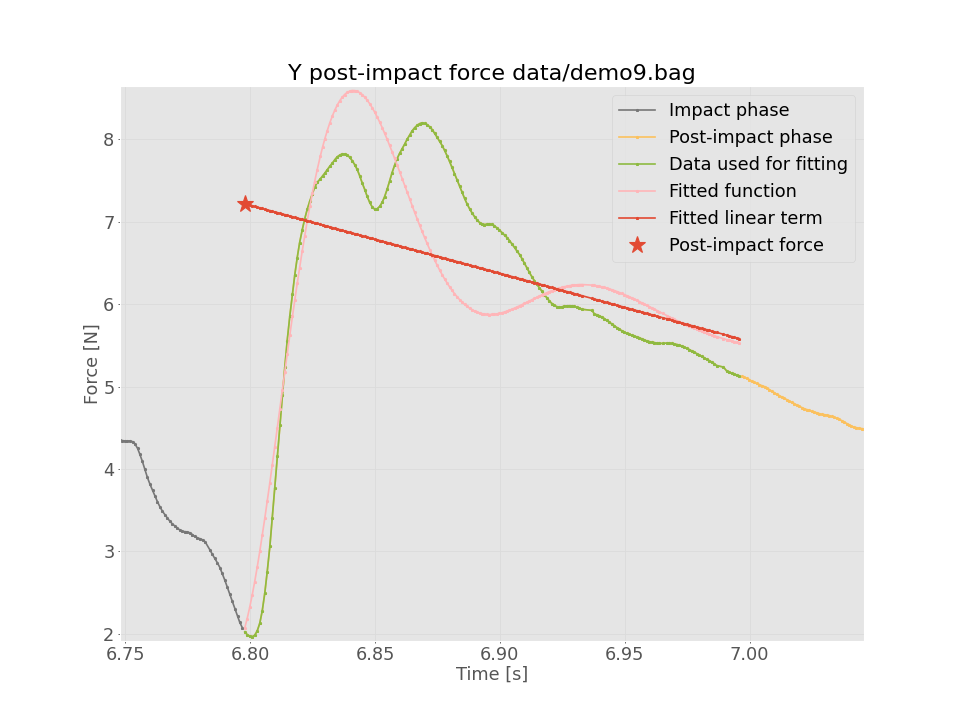

<IPython.core.display.Javascript object>


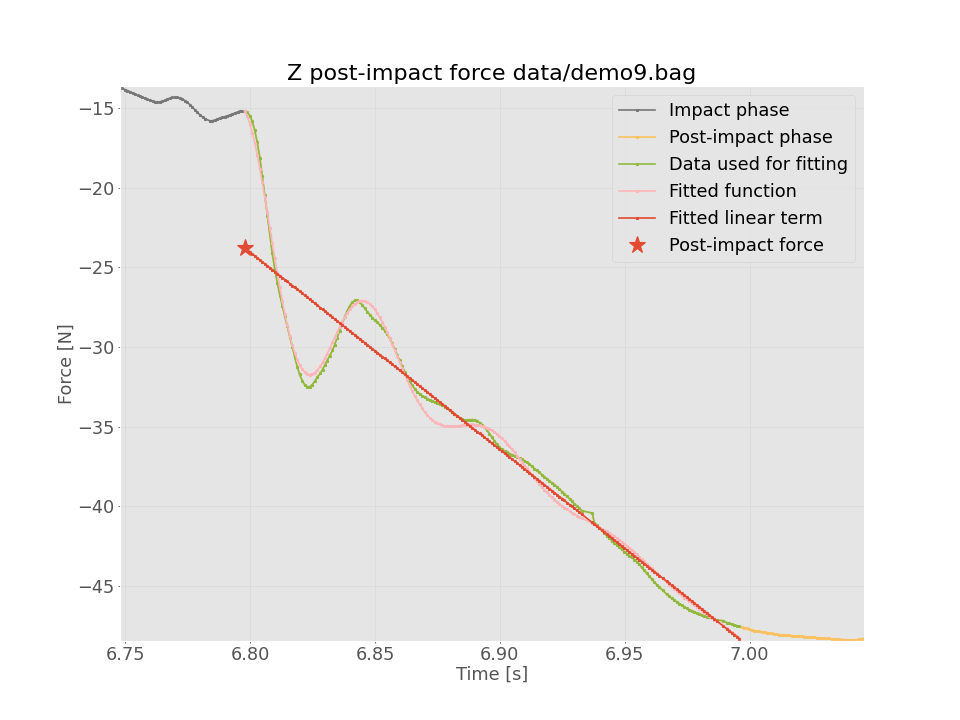

<IPython.core.display.Javascript object>


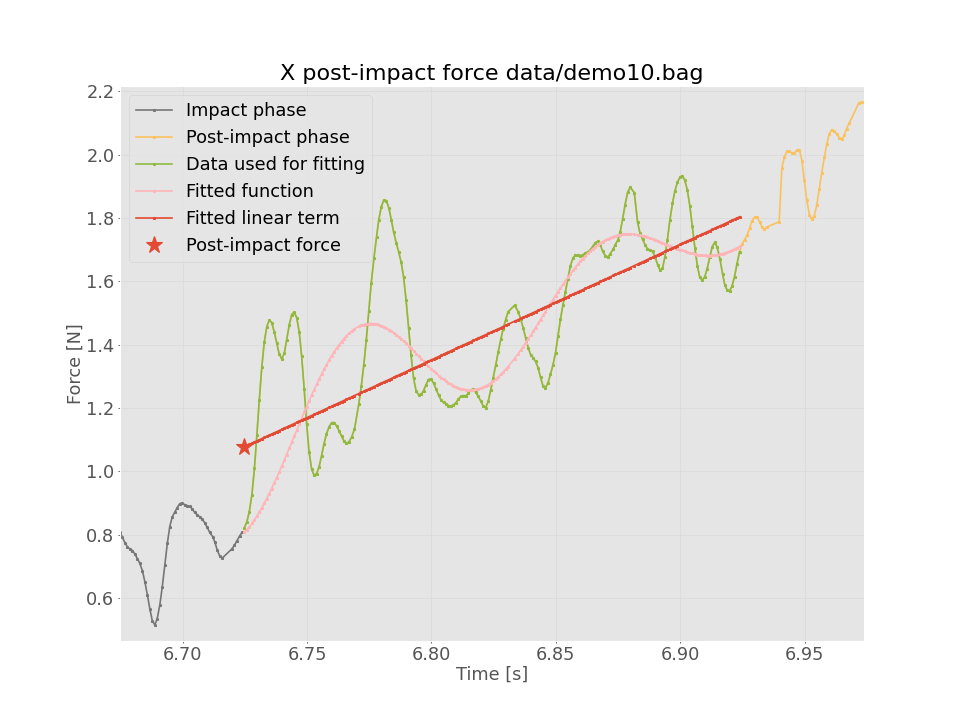

<IPython.core.display.Javascript object>


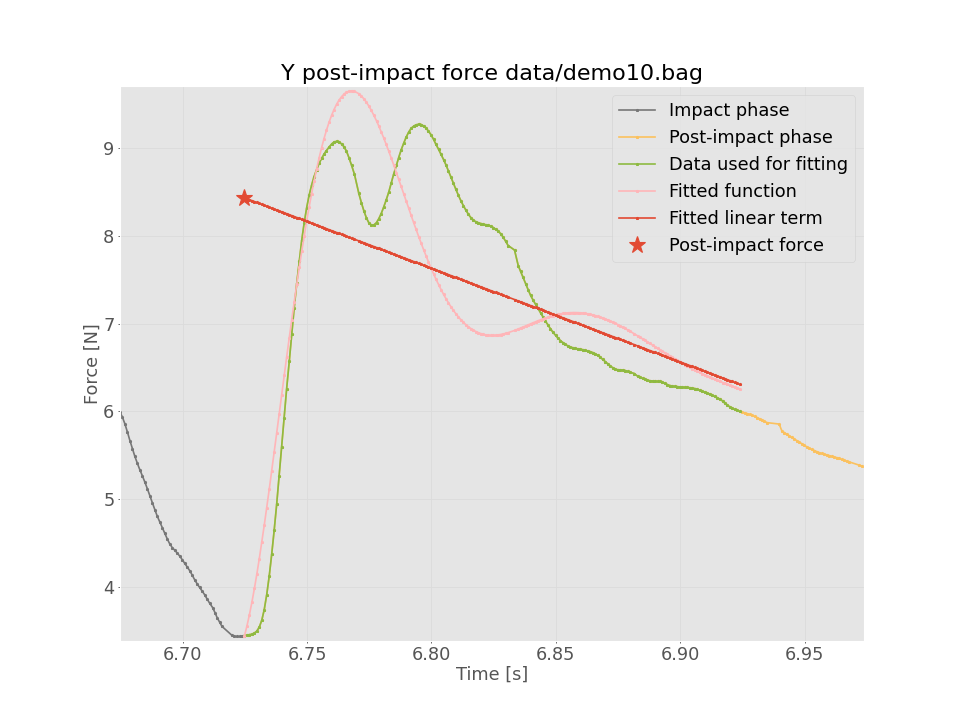

<IPython.core.display.Javascript object>


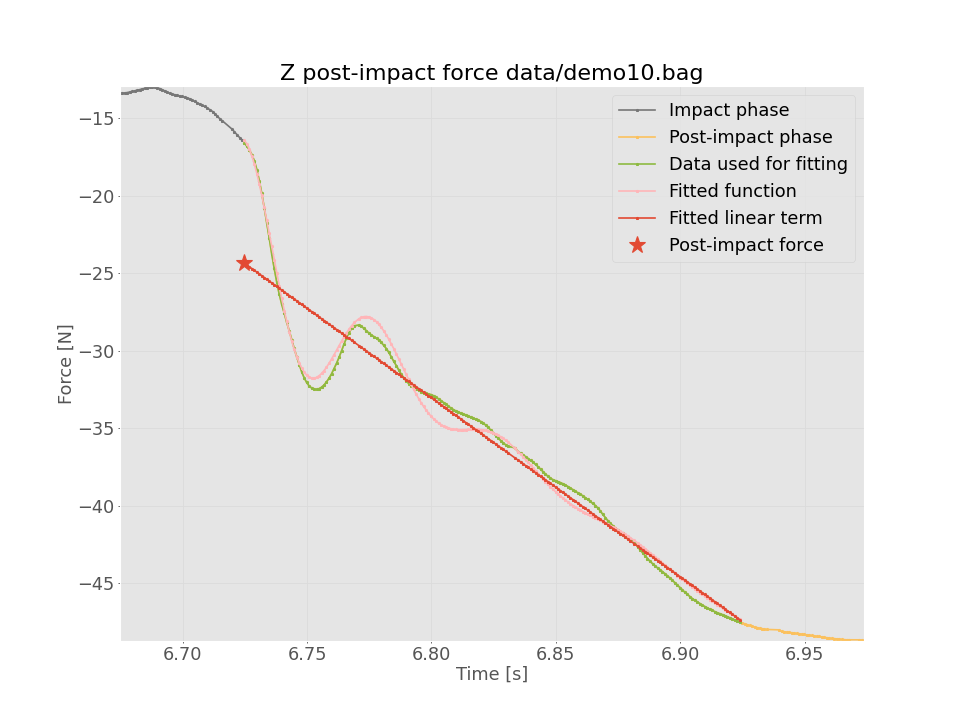

In [6]:
# Plot fitted velocity

for i in range(len(config.demos)):    
    for j in range(3):
        
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        plt.plot(impact_phase_velocity_data[i].time, impact_phase_velocity_data[i].get_index(j).value, 'C3-*', linewidth=config.linewidth, markersize=config.markersize3, label='Impact phase')
        plt.plot(post_impact_velocity_data[i].time, post_impact_velocity_data[i].get_index(j).value, f'C{4}-*', linewidth=config.linewidth, markersize=config.markersize3, label='Post-impact phase')
        plt.plot(velocity_to_be_fitted_data[i].time, velocity_to_be_fitted_data[i].get_index(j).value, f'C{5}-*', linewidth=config.linewidth, markersize=config.markersize3, label='Data used for fitting')
        plt.plot(fitted_data[i].time, fitted_data[i].get_index(j).value, f'C{6}-*', linewidth=config.linewidth, markersize=config.markersize3, label='Fitted function')
        plt.plot(fitted_linear_data[i].time, fitted_linear_data[i].get_index(j).value, f'C{0}-*', linewidth=config.linewidth, markersize=config.markersize3, label='Fitted linear term')
        plt.plot(fitted_linear_data[i][0].time, fitted_linear_data[i][0][j].value, f'C{0}*', linewidth=config.linewidth, markersize=config.markersize1, label='Post-impact force')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Force [N]',fontsize=config.fontsize2)
        plt.title(f'{config.labels[j]} post-impact force ' + config.demos[i],fontsize=config.fontsize1)
        if config.xlim is not None:
            x_min = velocity_to_be_fitted_data[i][0].time + config.xlim[0]
            x_max = velocity_to_be_fitted_data[i][-1].time + config.xlim[-1]
            sub_ydata1 = post_impact_velocity_data[i][bisect(post_impact_velocity_data[i].time, x_min):bisect(post_impact_velocity_data[i].time, x_max)].get_index(j).value
            sub_ydata2 = fitted_data[i][bisect(fitted_data[i].time, x_min):bisect(fitted_data[i].time, x_max)].get_index(j).value
            sub_ydata3 = fitted_linear_data[i][bisect(fitted_linear_data[i].time, x_min):bisect(fitted_linear_data[i].time, x_max)].get_index(j).value
            sub_ydata4 = impact_phase_velocity_data[i][bisect(impact_phase_velocity_data[i].time, x_min):bisect(impact_phase_velocity_data[i].time, x_max)].get_index(j).value
            
            y_min = min([min(sub_ydata1), min(sub_ydata2), min(sub_ydata3), min(sub_ydata4)]) - 0.05
            y_max = max([max(sub_ydata1), max(sub_ydata2), max(sub_ydata3), max(sub_ydata4)]) + 0.05
            plt.xlim((x_min, x_max))
            plt.ylim((y_min, y_max))